# Note:  
V1 
- Create flow of modelling with RFclassification.
- Add GridSearch with CV instead of manually CV.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

seed_no = 572

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Load data

In [3]:
df_trn = pd.read_csv('data/x_train_82.csv', index_col='index')
df_tst = pd.read_csv('data/x_test_82.csv', index_col='index')

In [4]:
df_trn.rename(columns={'Fat ': 'Fat', 'Temprature': 'Temperature'}, inplace=True)
df_tst.rename(columns={'Fat ': 'Fat', 'Temprature': 'Temperature'}, inplace=True)

In [5]:
print(df_trn.shape, df_tst.shape)
df_trn.head()

(847, 8) (212, 8)


,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,medium
824,6.8,45,0,0,0,1,255,medium
602,5.6,50,0,1,1,1,255,low
347,8.6,55,0,1,1,1,255,low
753,6.6,38,0,0,0,0,255,medium


# Preprocessing function

## Label encoding

In [6]:
def encode_label(df_in):
    df_fnc = df_in.copy()
    df_fnc.loc[df_fnc['Grade']=='low', 'Grade'] = 0
    df_fnc.loc[df_fnc['Grade']=='medium', 'Grade'] = 1
    df_fnc.loc[df_fnc['Grade']=='high', 'Grade'] = 2
    df_fnc['Grade'] = df_fnc['Grade'].astype(int)
    
    return df_fnc

df_trn = encode_label(df_trn)
df_tst = encode_label(df_tst)

In [7]:
df_trn.head(2)

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
244,6.5,38,1,0,1,0,255,1
824,6.8,45,0,0,0,1,255,1


In [8]:
# Prepare for training
y_trn = df_trn[['Grade']]
X_trn = df_trn.drop(columns='Grade')

y_tst = df_tst[['Grade']]
X_tst = df_tst.drop(columns='Grade')

print(y_trn.shape, X_trn.shape)
print(y_tst.shape, X_tst.shape)

(847, 1) (847, 7)
(212, 1) (212, 7)


## Create new features

### Frequency of Taste, Odor, Turbidity and Fat combination

In [9]:
list_freq_int = ['Taste', 'Odor', 'Turbidity', 'Fat']
df_trn_db_freq = df_trn[list_freq_int+['pH']].groupby(list_freq_int).count()/df_trn.shape[0]
df_trn_db_freq.columns = ['freq_TOTF']
df_trn_db_freq = df_trn_db_freq.reset_index()
df_trn_db_freq.head(3)

,Taste,Odor,Turbidity,Fat,freq_TOTF
0,0,0,0,0,0.145218
1,0,0,0,1,0.061393
2,0,0,1,0,0.056671


In [10]:
X_trn = pd.merge(X_trn, df_trn_db_freq, on=list_freq_int, how='left')
X_tst = pd.merge(X_tst, df_trn_db_freq, on=list_freq_int, how='left')
X_trn.index = df_trn.index
X_tst.index = df_tst.index

### Interaction

In [11]:
from sklearn.preprocessing import PolynomialFeatures

# Create PolynomialFeatures object with degree 2
poly = PolynomialFeatures(degree=2, include_bias=False)

# Transform the original features to polynomial features
X_trn = pd.DataFrame(poly.fit_transform(X_trn), columns=poly.get_feature_names_out(X_trn.columns))
X_trn.columns = [i.replace(" ", "_").replace("^", "_") for i in X_trn.columns]
X_tst = pd.DataFrame(poly.transform(X_tst), columns=poly.get_feature_names_out(X_tst.columns))
X_tst.columns = [i.replace(" ", "_").replace("^", "_") for i in X_tst.columns]

X_trn.index = df_trn.index
X_tst.index = df_tst.index

## Normalization

In [12]:
# Scaler
scaler = StandardScaler()
X_trn_scale = pd.DataFrame(scaler.fit_transform(X_trn))
X_trn_scale.columns = X_trn.columns
X_trn_scale.index = X_trn.index

X_tst_scale = pd.DataFrame(scaler.transform(X_tst))
X_tst_scale.columns = X_tst.columns
X_tst_scale.index = X_tst.index

In [13]:
X_trn_scale.head(2)

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,freq_TOTF,pH_2,pH_Temperature,pH_Taste,pH_Odor,pH_Fat,pH_Turbidity,pH_Colour,pH_freq_TOTF,Temperature_2,Temperature_Taste,Temperature_Odor,Temperature_Fat,Temperature_Turbidity,Temperature_Colour,Temperature_freq_TOTF,Taste_2,Taste_Odor,Taste_Fat,Taste_Turbidity,Taste_Colour,Taste_freq_TOTF,Odor_2,Odor_Fat,Odor_Turbidity,Odor_Colour,Odor_freq_TOTF,Fat_2,Fat_Turbidity,Fat_Colour,Fat_freq_TOTF,Turbidity_2,Turbidity_Colour,Turbidity_freq_TOTF,Colour_2,Colour_freq_TOTF,freq_TOTF_2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
244,-0.091649,-0.607768,0.902056,-0.882843,0.691509,-0.989430,0.744513,0.606848,-0.207039,-0.463022,0.828546,-0.83186,0.642112,-0.926001,-0.028731,0.539113,-0.532929,0.61031,-0.865362,0.348500,-0.932189,-0.555986,0.148823,0.902056,-0.58144,1.092841,-0.648954,0.930007,1.156470,-0.882843,-0.757858,-0.697112,-0.882587,-0.732535,0.691509,-0.835102,0.715323,0.862511,-0.989430,-0.989203,-0.899217,0.74709,0.637579,0.554250
824,0.122987,0.067163,-1.108579,-0.882843,-1.446112,1.010683,0.744513,-1.160930,0.020200,0.083521,-1.035750,-0.83186,-1.345041,0.982737,0.189255,-1.002506,-0.038594,-1.04040,-0.865362,-1.337479,0.904102,0.122318,-1.004887,-1.108579,-0.58144,-0.915047,-0.648954,-1.108244,-0.938499,-0.882843,-0.757858,-0.697112,-0.882587,-0.732535,-1.446112,-0.835102,-1.445592,-1.261898,1.010683,1.031252,-0.069340,0.74709,-1.142001,-1.274461


# Train model

## CV - Hyperparameters tuning

In [14]:
# Create a stratified 5-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_no)

In [15]:
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=seed_no)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           cv=skf, 
                           scoring='f1_macro',
                           verbose=0)
grid_search.fit(X_trn_scale, y_trn)

# # Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
print("Best Score:", grid_search.best_score_)

# Use the best model to make predictions on the test set
best_rf_model = grid_search.best_estimator_

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Score: 0.998962417807806


In [16]:
# Manual CV
# # Create a stratified 5-fold cross-validator
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_no)

# list_score_f1 = []
# list_score_precision = []
# list_score_recall = []
# list_score_acc = []

# # Iterate through the folds
# for fold, (train_index, val_index) in enumerate(skf.split(X_trn, y_trn)):
#     X_train, X_val = X_trn.iloc[train_index, ], X_trn.iloc[val_index, ]
#     y_train, y_val = y_trn.iloc[train_index, ], y_trn.iloc[val_index, ]
    
# #     print(f"Fold {fold + 1} - Training set: {len(X_train)}, Testing set: {len(X_val)}")

#     # Train model
#     ## Create a Random Forest Classifier
#     rf_classifier_cv = RandomForestClassifier(n_estimators=100, random_state=seed_no)

#     ## Train the model
#     rf_classifier_cv.fit(X_train, y_train)
    
#     ## Make predictions on the test set
#     y_val_pred = rf_classifier_cv.predict(X_val)

#     ## Evaluate the model/log score
#     dict_rep = classification_report(y_val, y_val_pred, output_dict=True)
#     score_f1 = dict_rep['macro avg']['f1-score']
#     score_precision = dict_rep['macro avg']['precision']
#     score_recall = dict_rep['macro avg']['recall']
#     score_accuracy = accuracy_score(y_val, y_val_pred)
#     list_score_f1.append(score_f1)
#     list_score_precision.append(score_precision)
#     list_score_recall.append(score_recall)
#     list_score_acc.append(score_accuracy)
    
# score_f1_mean = np.mean(list_score_f1)
# score_precision_mean = np.mean(list_score_precision)
# score_recall_mean = np.mean(list_score_recall)
# score_acc_mean = np.mean(list_score_acc)

# score_f1_std = np.std(list_score_f1)
# score_precision_std = np.std(list_score_precision)
# score_recall_std = np.std(list_score_recall)
# score_acc_std = np.std(list_score_acc)

# print("Evaluation CV:")
# print(f"F1-score\t: {score_f1_mean:.06f} ({score_f1_std:.06f})")
# print(f"Precision\t: {score_precision_mean:.06f} ({score_precision_std:.06f})")
# print(f"Recall\t\t: {score_recall_mean:.06f} ({score_recall_std:.06f})")
# print(f"Accuracy\t: {score_acc_mean:.06f} ({score_acc_std:.06f})")

## Retrain the whole training data with the best parameters

In [17]:
# GridSearchCV return the retrained model with whole dataset
y_trn_pred = best_rf_model.predict(X_trn_scale)

## Evaluate the model/log score
print(classification_report(y_trn, y_trn_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00       299
           2       1.00      1.00      1.00       205

    accuracy                           1.00       847
   macro avg       1.00      1.00      1.00       847
weighted avg       1.00      1.00      1.00       847



In [18]:
# Manual CV
# # Train model
# ## Create a Random Forest Classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=seed_no)

# ## Train the model
# rf_classifier.fit(X_trn, y_trn)

# ## Make predictions on the test set
# y_trn_pred = rf_classifier.predict(X_trn)

# ## Evaluate the model/log score
# dict_rep = classification_report(y_trn, y_trn_pred, output_dict=True)
# print(classification_report(y_trn, y_trn_pred))

## Feature Importance

,Feature,Importance
0,pH,0.135829
12,pH_Fat,0.118458
14,pH_Colour,0.110262
9,pH_Temperature,0.080154
40,Turbidity_freq_TOTF,0.052416
19,Temperature_Fat,0.034784
16,Temperature_2,0.033246
8,pH_2,0.032621
32,Odor_Colour,0.031010
35,Fat_Turbidity,0.030079


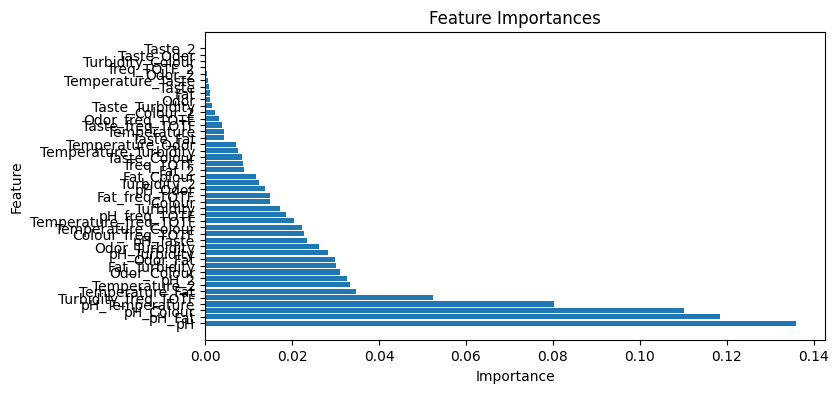

In [19]:
# Get feature importances
# feature_importances = rf_classifier.feature_importances_  # manual CV
feature_importances = best_rf_model.feature_importances_  # using GridSearch

# Get the corresponding feature names
feature_names = list(X_trn.columns)  # Assuming you have column names in your DataFrame X

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
display(importance_df)

# Plotting feature importances (optional)
plt.figure(figsize=(8, 4))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## Performance on Test data

In [20]:
# Make predictions on the test set
# y_test_pred = rf_classifier.predict(X_tst)
y_test_pred = best_rf_model.predict(X_tst_scale)


# Evaluate the model
accuracy = accuracy_score(y_tst, y_test_pred)
print(f"Accuracy: {accuracy}")

# Display classification report
print("Classification Report:")
print(classification_report(y_tst, y_test_pred))

Accuracy: 0.9952830188679245
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        86
           1       1.00      1.00      1.00        75
           2       1.00      0.98      0.99        51

    accuracy                           1.00       212
   macro avg       1.00      0.99      0.99       212
weighted avg       1.00      1.00      1.00       212



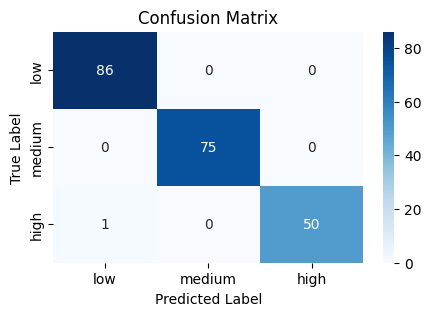

In [21]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_tst, y_test_pred)

# Display the confusion matrix using a heatmap
class_names = ['low', 'medium', 'high']
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# EDA Error (Testing dataset)

In [22]:
# Merge prediction with the testing dataset
df_test_perf = y_tst.copy()
df_test_perf['pred_test'] = y_test_pred
df_test_perf = X_tst.merge(df_test_perf, left_index=True, right_index=True)

# Explore Error
df_test_perf[df_test_perf['Grade']!=df_test_perf['pred_test']]

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,freq_TOTF,pH_2,pH_Temperature,pH_Taste,pH_Odor,pH_Fat,pH_Turbidity,pH_Colour,pH_freq_TOTF,Temperature_2,Temperature_Taste,Temperature_Odor,Temperature_Fat,Temperature_Turbidity,Temperature_Colour,Temperature_freq_TOTF,Taste_2,Taste_Odor,Taste_Fat,Taste_Turbidity,Taste_Colour,Taste_freq_TOTF,Odor_2,Odor_Fat,Odor_Turbidity,Odor_Colour,Odor_freq_TOTF,Fat_2,Fat_Turbidity,Fat_Colour,Fat_freq_TOTF,Turbidity_2,Turbidity_Colour,Turbidity_freq_TOTF,Colour_2,Colour_freq_TOTF,freq_TOTF_2,Grade,pred_test
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6.6,36.0,0.0,1.0,0.0,1.0,253.0,0.001181,43.56,237.6,0.0,6.6,0.0,6.6,1669.8,0.007792,1296.0,0.0,36.0,0.0,36.0,9108.0,0.042503,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,253.0,0.001181,0.0,0.0,0.0,0.0,1.0,253.0,0.001181,64009.0,0.298701,0.000001,2,0


In [23]:
df_tst.loc[[1, ]]

,pH,Temperature,Taste,Odor,Fat,Turbidity,Colour,Grade
index,,,,,,,,
1,6.6,36,0,1,0,1,253,2


In [24]:
df_trn.groupby("Grade").describe()

pH                                              Temperature  \
       count      mean       std  min  25%  50%  75%  max       count   
Grade                                                                   
0      343.0  6.578426  2.193385  3.0  4.7  6.8  8.6  9.5       343.0   
1      299.0  6.638127  0.131146  6.4  6.5  6.6  6.8  6.8       299.0   
2      205.0  6.696585  0.108637  6.5  6.6  6.7  6.8  6.8       205.0   

                                                           Taste            \
            mean        std   min   25%   50%   75%   max  count      mean   
Grade                                                                        
0      50.466472  13.495653  34.0  40.0  45.0  55.0  90.0  343.0  0.603499   
1      39.722408   3.660949  34.0  37.0  38.0  45.0  45.0  299.0  0.391304   
2      40.673171   3.718727  35.0  37.0  40.0  45.0  45.0  205.0  0.697561   

                                           Odor                                \
            std  min  25%  50%  75%  max  count      mean       std  min  25%   
Grade                                                                           
0      0.489885  0.0  0.0  1.0  1.0  1.0  343.0  0.486880  0.500558  0.0  0.0   
1      0.488860  0.0  0.0  0.0  1.0  1.0  299.0  0.167224  0.373801  0.0  0.0   
2      0.460439  0.0  0.0  1.0  1.0  1.0  205.0  0.751220  0.433365  0.0  1.0   

                        Fat                                               \
       50%  75%  max  count      mean       std  min  25%  50%  75%  max   
Grade                                                                      
0      0.0  1.0  1.0  343.0  0.737609  0.440577  0.0  0.0  1.0  1.0  1.0   
1      0.0  0.0  1.0  299.0  0.384615  0.487320  0.0  0.0  0.0  1.0  1.0   
2      1.0  1.0  1.0  205.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   

      Turbidity                                              Colour  \
          count      mean       std  min  25%  50%  75%  max  count   
Grade                                                                 
0         343.0  0.731778  0.443681  0.0  0.0  1.0  1.0  1.0  343.0   
1         299.0  0.130435  0.337346  0.0  0.0  0.0  0.0  1.0  299.0   
2         205.0  0.629268  0.484183  0.0  0.0  1.0  1.0  1.0  205.0   

                                                                
             mean       std    min    25%    50%    75%    max  
Grade                                                           
0      252.746356  3.223150  245.0  250.0  255.0  255.0  255.0  
1      250.107023  5.340291  240.0  245.0  255.0  255.0  255.0  
2      252.424390  3.822071  245.0  250.0  255.0  255.0  255.0